In [2]:
import csv
import pandas as pd
import numpy as np
import json
import jsonlines
import re
from termcolor import colored
csv.field_size_limit(100000000)

from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import shap

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

try:
    from urllib.parse import urlparse
except ImportError:
     from urlparse import urlparse
%matplotlib inline 

import matplotlib.dates as mdates
import matplotlib.ticker as tick

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.float_format = '{:.4f}'.format

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RandomForestClassifier
## TweetsCov19
### (Tweet content + user features)

In [3]:
path = '../data/df_tweetscov19_sample_200000.tsv'

df_tweetscov19_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference' ])

print('Shape :', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape : (200000, 95)


Tweet_Id                          Username  Retweets  Favorites  \
0  1239921910114369537  e91f45964db23b2bec20d15fc6c501ae         0          0   
1  1221651394068992001  7b8c3d61b23ef22900c7e8cac3ef655a         9         21   
2  1247547192606437376  aeed110177e1f18d8e5721dc4257c2aa        12         25   
3  1228281231713894401  bf8d92180630f872868ab15fafefa6da         0          0   
4  1239619450455941123  f99928784e541662228f9c85519a0d75         0          0   

   Vader_neg  Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  \
0    -0.0000     1.0000     0.0000     0.0000             0             0   
1    -0.0320     0.7210     0.2470     0.9431             0             0   
2    -0.1340     0.5990     0.2680     0.7003             1             0   
3    -0.0000     1.0000     0.0000     0.0000             0             0   
4    -0.1620     0.8380     0.0000    -0.6808             0             0   

   Text_len  URLs_num  readability  Emoji_num  Emoji_sent  \
0        24         0      33.5750          0      0.0000   
1       268         1      98.7810          0      0.0000   
2        88         0      53.6550          2      0.4420   
3       105         0      99.4920          0      0.0000   
4       144         0      62.6250          2      0.3330   

   tweet_politic_polarisation  tweet_science_polarisation  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   tweet_moderacy_polarisation  social  family  friend  female   male    work  \
0                       0.0000 25.0000  0.0000  0.0000  0.0000 0.0000 25.0000   
1                       0.0000 10.1700  0.0000  0.0000  0.0000 5.0800  0.0000   
2                       0.0000  7.1400  0.0000  0.0000  7.1400 0.0000  0.0000   
3                       0.0000  0.0000  0.0000  0.0000  0.0000 0.0000  0.0000   
4                       0.0000  4.1700  0.0000  0.0000  0.0000 0.0000  0.0000   

   leisure   home  money  relegion  death  informal  swear  netspeak  assent  \
0   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
1   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
2   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
3   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
4   0.0000 0.0000 0.0000    0.0000 0.0000    4.1700 4.1700    0.0000  0.0000   

   nonflu  filler    body  health  sexual  ingest  posemo  negemo    anx  \
0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  6.7800  0.0000 0.0000   
2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  7.1400 0.0000   
3  0.0000  0.0000 10.5300  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
4  0.0000  0.0000  4.1700  0.0000  0.0000  0.0000  0.0000  8.3300 0.0000   

   anger    sad  insight  cause  discrep  tentat  certain  differ  \
0 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
1 0.0000 0.0000   3.3900 0.0000   0.0000  0.0000   0.0000  0.0000   
2 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
3 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
4 4.1700 0.0000   4.1700 4.1700   0.0000  0.0000   0.0000  4.1700   

   affiliation  achiev  power  reward   risk  focuspast  focuspresent  \
0       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        0.0000   
1       3.3900  1.6900 0.0000  1.6900 0.0000     6.7800        5.0800   
2       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        0.0000   
3       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        0.0000   
4       0.0000  0.0000 0.0000  4.1700 4.1700     4.1700        8.3300   

   focusfuture       i     we     you  shehe   they

In [4]:
df_tweetscov19_user = df_tweetscov19_user.sample(frac=1).reset_index(drop=True)

print('Shape: ', df_tweetscov19_user.shape)
df_tweetscov19_user.head()

Shape:  (200000, 95)


Tweet_Id                          Username  Retweets  Favorites  \
0  1251274628019953671  de89313c92b9f26d50c23ee8a1b5040b        15        141   
1  1219540612552126464  a7599f8acce935867ee50dd6aebd52d6         0          0   
2  1258456514102263816  d63e8bed674593b6d45faa8acc8ce2e3         1          0   
3  1233581946992840704  66b181cb326f23ee18448345478711da         0          0   
4  1182475594250014720  60b58a9f33d82a7109f904b2a5fad37b         0          0   

   Vader_neg  Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  \
0    -0.1660     0.8110     0.0230    -0.8357             0             0   
1    -0.0000     1.0000     0.0000     0.0000             0             1   
2    -0.0270     0.9730     0.0000    -0.0258             0             0   
3    -0.0910     0.9090     0.0000    -0.4939             1             0   
4    -0.1000     0.9000     0.0000    -0.2732             2             1   

   Text_len  URLs_num  readability  Emoji_num  Emoji_sent  \
0       259         0      70.1450          0      0.0000   
1        61         0      86.7050          0      0.0000   
2       280         0      45.6970          0      0.0000   
3       243         0      40.0270          1      0.0000   
4       141         0      34.2550          0      0.0000   

   tweet_politic_polarisation  tweet_science_polarisation  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   tweet_moderacy_polarisation  social  family  friend  female   male    work  \
0                       0.0000  4.0000  0.0000  0.0000  0.0000 0.0000  6.0000   
1                       0.0000  9.0900  0.0000  0.0000  0.0000 0.0000  0.0000   
2                       0.0000  4.4400  0.0000  0.0000  0.0000 0.0000  8.8900   
3                       0.0000  5.4100  0.0000  0.0000  2.7000 0.0000  5.4100   
4                       0.0000  5.0000  0.0000  0.0000  0.0000 5.0000 15.0000   

   leisure   home   money  relegion  death  informal  swear  netspeak  assent  \
0   0.0000 2.0000  2.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
1   0.0000 0.0000  0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
2   0.0000 0.0000 11.1100    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
3   5.4100 0.0000  2.7000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
4   0.0000 0.0000  5.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   

   nonflu  filler   body  health  sexual  ingest  posemo  negemo    anx  \
0  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  4.0000 0.0000   
1  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
2  0.0000  0.0000 0.0000  2.2200  0.0000  0.0000  2.2200  0.0000 0.0000   
3  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  2.7000 0.0000   
4  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   

   anger    sad  insight  cause  discrep  tentat  certain  differ  \
0 2.0000 0.0000   0.0000 0.0000   2.0000  0.0000   4.0000  0.0000   
1 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
2 0.0000 0.0000   0.0000 2.2200   0.0000  0.0000   0.0000  0.0000   
3 0.0000 2.7000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
4 0.0000 0.0000   0.0000 0.0000   0.0000  5.0000   0.0000  0.0000   

   affiliation  achiev  power  reward   risk  focuspast  focuspresent  \
0       0.0000  2.0000 2.0000  0.0000 2.0000     2.0000       14.0000   
1       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000       18.1800   
2       0.0000  2.2200 2.2200  0.0000 4.4400     0.0000        6.6700   
3       2.7000  2.7000 0.0000  0.0000 0.0000     5.4100        0.0000   
4       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        5.0000   

   focusfuture      i     we    you  shehe   they  

In [5]:
features = df_tweetscov19_user.columns
features

Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [6]:
df_tweetscov19_user['Is_deleted'] = np.where(df_tweetscov19_user['Is_deleted'] == True, 1, 0)
df_tweetscov19_user.head()

Tweet_Id                          Username  Retweets  Favorites  \
0  1251274628019953671  de89313c92b9f26d50c23ee8a1b5040b        15        141   
1  1219540612552126464  a7599f8acce935867ee50dd6aebd52d6         0          0   
2  1258456514102263816  d63e8bed674593b6d45faa8acc8ce2e3         1          0   
3  1233581946992840704  66b181cb326f23ee18448345478711da         0          0   
4  1182475594250014720  60b58a9f33d82a7109f904b2a5fad37b         0          0   

   Vader_neg  Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  \
0    -0.1660     0.8110     0.0230    -0.8357             0             0   
1    -0.0000     1.0000     0.0000     0.0000             0             1   
2    -0.0270     0.9730     0.0000    -0.0258             0             0   
3    -0.0910     0.9090     0.0000    -0.4939             1             0   
4    -0.1000     0.9000     0.0000    -0.2732             2             1   

   Text_len  URLs_num  readability  Emoji_num  Emoji_sent  \
0       259         0      70.1450          0      0.0000   
1        61         0      86.7050          0      0.0000   
2       280         0      45.6970          0      0.0000   
3       243         0      40.0270          1      0.0000   
4       141         0      34.2550          0      0.0000   

   tweet_politic_polarisation  tweet_science_polarisation  \
0                      0.0000                      0.0000   
1                      0.0000                      0.0000   
2                      0.0000                      0.0000   
3                      0.0000                      0.0000   
4                      0.0000                      0.0000   

   tweet_moderacy_polarisation  social  family  friend  female   male    work  \
0                       0.0000  4.0000  0.0000  0.0000  0.0000 0.0000  6.0000   
1                       0.0000  9.0900  0.0000  0.0000  0.0000 0.0000  0.0000   
2                       0.0000  4.4400  0.0000  0.0000  0.0000 0.0000  8.8900   
3                       0.0000  5.4100  0.0000  0.0000  2.7000 0.0000  5.4100   
4                       0.0000  5.0000  0.0000  0.0000  0.0000 5.0000 15.0000   

   leisure   home   money  relegion  death  informal  swear  netspeak  assent  \
0   0.0000 2.0000  2.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
1   0.0000 0.0000  0.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
2   0.0000 0.0000 11.1100    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
3   5.4100 0.0000  2.7000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   
4   0.0000 0.0000  5.0000    0.0000 0.0000    0.0000 0.0000    0.0000  0.0000   

   nonflu  filler   body  health  sexual  ingest  posemo  negemo    anx  \
0  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  4.0000 0.0000   
1  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   
2  0.0000  0.0000 0.0000  2.2200  0.0000  0.0000  2.2200  0.0000 0.0000   
3  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  2.7000 0.0000   
4  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 0.0000   

   anger    sad  insight  cause  discrep  tentat  certain  differ  \
0 2.0000 0.0000   0.0000 0.0000   2.0000  0.0000   4.0000  0.0000   
1 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
2 0.0000 0.0000   0.0000 2.2200   0.0000  0.0000   0.0000  0.0000   
3 0.0000 2.7000   0.0000 0.0000   0.0000  0.0000   0.0000  0.0000   
4 0.0000 0.0000   0.0000 0.0000   0.0000  5.0000   0.0000  0.0000   

   affiliation  achiev  power  reward   risk  focuspast  focuspresent  \
0       0.0000  2.0000 2.0000  0.0000 2.0000     2.0000       14.0000   
1       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000       18.1800   
2       0.0000  2.2200 2.2200  0.0000 4.4400     0.0000        6.6700   
3       2.7000  2.7000 0.0000  0.0000 0.0000     5.4100        0.0000   
4       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000        5.0000   

   focusfuture      i     we    you  shehe   they  

In [7]:
#df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [8]:
def get_X_y(df, features):
    
    if 'Is_deleted' not in features:
        features = np.append(features, 'Is_deleted')
        
    df = df[features.tolist()]
    X = df.drop('Is_deleted', axis=1)
    y = df['Is_deleted']

    y = y.astype(int)
    print(X.shape)
    print(y.shape)
    
    return X,y

In [9]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(200000, 89)
(200000,)


In [10]:
def split_train_test_valid(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=15)
    #X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=15)
    print(X_train.shape)
    print(X_test.shape)
    #print(X_valid.shape)

    print(y_train.shape)
    print(y_test.shape)
    #print(y_valid.shape)
    return  X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [12]:
def fit_random_forest_clf(X,y):
    
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X,y)
    return clf

In [13]:
def test_random_forest_clf(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    print('Accuracy :', accuracy_score(y_test, y_pred))
    

In [14]:
rf_model = fit_random_forest_clf(X_train, y_train)

In [14]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_RF_Benutzer_Inhalt_alle_ohne_moderacy_2.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [15]:
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.607


In [16]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.56      0.59      2003
           1       0.60      0.65      0.62      1997

    accuracy                           0.61      4000
   macro avg       0.61      0.61      0.61      4000
weighted avg       0.61      0.61      0.61      4000



In [15]:
def plot_confusion_matrix(y_test, y_pred, classes, titel):
    
    confusion_mx = confusion_matrix(y_test, y_pred)
    confusion_mx = confusion_mx / confusion_mx.sum(axis=1).reshape(-1,1)
    
    sns.heatmap(confusion_mx, xticklabels = classes, yticklabels = classes, annot=True)
    plt.title(titel)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

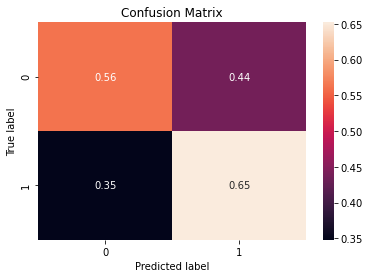

In [18]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [16]:
def print_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, scoring='precision')
    print(" percision : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='f1')
    print(" f1        : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))
    scores = cross_val_score(model, X, y, cv=10, scoring='recall')
    print(" recall    : %0.2f +/- %0.3f" % (scores.mean(), scores.std()))

In [20]:
clf_cv = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.60 +/- 0.010
 f1        : 0.63 +/- 0.009
 recall    : 0.65 +/- 0.010


***

In [59]:
def features_classifier_(df, model):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = model.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)

    df_column_feature = df_column_feature.reset_index()
    df_column_feature
    return df_column_feature

In [22]:
f_importances = features_classifier_(X, rf_model)
f_importances

index                                  Feature  importance
0      83                          user_Reputation      0.0593
1      10                              readability      0.0374
2       8                                 Text_len      0.0356
3      84               user_vadercompound_average      0.0323
4      63                                     prep      0.0259
5       5                                vader_com      0.0252
6      68                                     verb      0.0249
7       3                                Vader_neu      0.0240
8      54                             focuspresent      0.0211
9      85           tweet_vadercompound_difference      0.0209
10     78                                    space      0.0204
11     16                                   social      0.0194
12      4                                Vader_pos      0.0192
13     64                                  auxverb      0.0192
14     62                                  article      0.0185
15     79                                     time      0.0178
16      2                                Vader_neg      0.0175
17     66                                     conj      0.0174
18     61                                    ipron      0.0171
19      0                                 Retweets      0.0159
20     65                                   adverb      0.0156
21     69                                      adj      0.0152
22      1                                Favorites      0.0149
23     53                                focuspast      0.0138
24     80              user_political_polarisation      0.0136
25     50                                    power      0.0133
26     21                                     work      0.0126
27     37                                   posemo      0.0123
28     47                                   differ      0.0115
29      7                             Mentions_num      0.0114
30     73                                    quant      0.0113
31     77                                   motion      0.0111
32      6                             Hashtags_num      0.0107
33     70                                  compare      0.0105
34     38                                   negemo      0.0104
35     45                                   tentat      0.0104
36     48                              affiliation      0.0102
37     43                                    cause      0.0100
38     42                                  insight      0.0099
39     46                                  certain      0.0096
40     71                                 interrog      0.0092
41     49                                   achiev      0.0091
42     58                                      you      0.0088
43     56                                        i      0.0088
44     51                                   reward      0.0088
45     27                                 informal      0.0086
46     12                               Emoji_sent      0.0085
47     55                              focusfuture      0.0085
48      9                                 URLs_num      0.0085
49     44                                  discrep      0.0083
50     74                                      see      0.0081
51     82               user_moderacy_polarisation      0.0079
52     22                                  leisure      0.0077
53     81                user_science_polarisation      0.0075
54     67                                   negate      0.0074
55     34                                   health      0.0073
56     86  tweet_political_polarisation_difference      0.0072
57     24                                    money      0.0069
58     52                                     risk      0.0068
59     11                                Emoji_num      0.0065
60     60                                     they      0.0061
61     20                                     male      0.0060
62     57                          

In [23]:
f_importances = f_importances[f_importances['importance'] > 0.01]
f_importances = f_importances.Feature.values
print(f_importances)

['user_Reputation' 'readability' 'Text_len' 'user_vadercompound_average'
 'prep' 'vader_com' 'verb' 'Vader_neu' 'focuspresent'
 'tweet_vadercompound_difference' 'space' 'social' 'Vader_pos' 'auxverb'
 'article' 'time' 'Vader_neg' 'conj' 'ipron' 'Retweets' 'adverb' 'adj'
 'Favorites' 'focuspast' 'user_political_polarisation' 'power' 'work'
 'posemo' 'differ' 'Mentions_num' 'quant' 'motion' 'Hashtags_num'
 'compare' 'negemo' 'tentat' 'affiliation' 'cause']


In [24]:
len(f_importances)

38

In [25]:
X,y = get_X_y(df_tweetscov19_user, f_importances)

(20000, 38)
(20000,)


In [26]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 38)
(4000, 38)
(16000,)
(4000,)


In [27]:
rf_model = fit_random_forest_clf(X_train, y_train)

In [28]:
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.60475


In [29]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.56      0.59      2003
           1       0.60      0.65      0.62      1997

    accuracy                           0.60      4000
   macro avg       0.61      0.60      0.60      4000
weighted avg       0.61      0.60      0.60      4000



In [30]:
clf_cv = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.59 +/- 0.008
 f1        : 0.61 +/- 0.013
 recall    : 0.63 +/- 0.020


******

## SelectFromModel
### Tweetscov19(content + user)

In [31]:
%%time
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), threshold = 0.001)
selector.fit(X_train, y_train)

Wall time: 805 ms


SelectFromModel(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                threshold=0.001)

In [32]:
def features_classifier_selectfrommodell(df, selector):

    column_feature = {}

    for i, c in enumerate(df):
        #print(c, '   ', decisionTC.feature_importances_[i])

        column_feature[c] = selector.estimator_.feature_importances_[i]
        #print(c)
    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    df_column_feature = df_column_feature.reset_index()
    features = df.columns[selector.get_support()]
    df_column_feature = df_column_feature[0: len(features)]
    
    return df_column_feature

In [33]:
%%time
f_importances_sfm = features_classifier_selectfrommodell(X, selector)
f_importances_sfm

Wall time: 506 ms


index                         Feature  importance
0       0                 user_Reputation      0.0798
1       1                     readability      0.0517
2       2                        Text_len      0.0502
3       3      user_vadercompound_average      0.0455
4       4                            prep      0.0364
5       6                            verb      0.0353
6       7                       Vader_neu      0.0342
7       5                       vader_com      0.0341
8       8                    focuspresent      0.0302
9      11                          social      0.0299
10     10                           space      0.0295
11      9  tweet_vadercompound_difference      0.0294
12     14                         article      0.0264
13     12                       Vader_pos      0.0264
14     13                         auxverb      0.0262
15     24     user_political_polarisation      0.0258
16     15                            time      0.0250
17     18                           ipron      0.0248
18     17                            conj      0.0247
19     16                       Vader_neg      0.0239
20     19                        Retweets      0.0221
21     20                          adverb      0.0221
22     21                             adj      0.0215
23     23                       focuspast      0.0199
24     22                       Favorites      0.0198
25     26                            work      0.0185
26     25                           power      0.0185
27     28                          differ      0.0170
28     27                          posemo      0.0170
29     34                          negemo      0.0158
30     29                    Mentions_num      0.0157
31     31                          motion      0.0155
32     30                           quant      0.0151
33     36                     affiliation      0.0150
34     35                          tentat      0.0149
35     33                         compare      0.0148
36     37                           cause      0.0141
37     32                    Hashtags_num      0.0135

In [24]:
def transform_data(selector, df):
    
    features = df.columns[selector.get_support()]
    print('Number of selected features:', len(features))
    print('')
    print('Selected features: \n', features.tolist())

    X_new = selector.transform(X)

    return X_new

In [35]:
 X_new = transform_data(selector, X)

Number of selected features: 38

Selected features: 
 ['user_Reputation', 'readability', 'Text_len', 'user_vadercompound_average', 'prep', 'vader_com', 'verb', 'Vader_neu', 'focuspresent', 'tweet_vadercompound_difference', 'space', 'social', 'Vader_pos', 'auxverb', 'article', 'time', 'Vader_neg', 'conj', 'ipron', 'Retweets', 'adverb', 'adj', 'Favorites', 'focuspast', 'user_political_polarisation', 'power', 'work', 'posemo', 'differ', 'Mentions_num', 'quant', 'motion', 'Hashtags_num', 'compare', 'negemo', 'tentat', 'affiliation', 'cause']


In [36]:
clf_cv = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.59 +/- 0.008
 f1        : 0.61 +/- 0.013
 recall    : 0.63 +/- 0.020


***

## Rekursive Feature Elimination(RFE)
### tweetscov19(content + user)

In [20]:
%%time
selector = RFE(RandomForestClassifier(n_estimators=100, n_jobs=-1))
selector.fit(X_train, y_train)

Wall time: 10min 22s


RFE(estimator=RandomForestClassifier(n_jobs=-1))

In [21]:
def features_classifier_rfe(df, selector):

    column_feature = {}

    for i, c in enumerate(df):
        column_feature[c] = selector.estimator_.feature_importances_[i]
        #print(c)

    df_column_feature = pd.DataFrame(column_feature.items(), columns=['Feature','importance'])
    df_column_feature.sort_values(by = ['importance'], ascending = False, inplace = True)
    
    return df_column_feature.reset_index()

In [22]:
%%time
df_rfe_selected = X[X.columns[selector.get_support()]]
f_importances_rfe = features_classifier_rfe(df_rfe_selected, selector)
f_importances_rfe

Wall time: 808 ms


index                         Feature  importance
0      41                 user_Reputation      0.0772
1       9                     readability      0.0495
2       8                        Text_len      0.0488
3      42      user_vadercompound_average      0.0474
4      26                            prep      0.0341
5       5                       vader_com      0.0314
6       3                       Vader_neu      0.0314
7      30                            verb      0.0312
8      23                    focuspresent      0.0275
9      10                          social      0.0273
10     36                           space      0.0265
11     43  tweet_vadercompound_difference      0.0259
12     25                         article      0.0247
13     27                         auxverb      0.0244
14      4                       Vader_pos      0.0243
15     37                            time      0.0233
16     24                           ipron      0.0227
17      2                       Vader_neg      0.0225
18     29                            conj      0.0219
19     28                          adverb      0.0211
20      0                        Retweets      0.0200
21     31                             adj      0.0197
22      1                       Favorites      0.0187
23     22                       focuspast      0.0177
24     38     user_political_polarisation      0.0170
25     21                           power      0.0167
26     11                            work      0.0161
27     13                          posemo      0.0157
28     19                          differ      0.0151
29      7                    Mentions_num      0.0144
30     17                          tentat      0.0143
31     35                          motion      0.0143
32     20                     affiliation      0.0140
33     40      user_moderacy_polarisation      0.0139
34     14                          negemo      0.0138
35     34                           quant      0.0137
36     32                         compare      0.0135
37     15                         insight      0.0134
38     16                           cause      0.0130
39     18                         certain      0.0129
40     39       user_science_polarisation      0.0128
41     12                        informal      0.0127
42      6                    Hashtags_num      0.0121
43     33                        interrog      0.0116

In [25]:
 X_new = transform_data(selector, X)

Number of selected features: 44

Selected features: 
 ['Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'readability', 'social', 'work', 'informal', 'posemo', 'negemo', 'insight', 'cause', 'tentat', 'certain', 'differ', 'affiliation', 'power', 'focuspast', 'focuspresent', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'verb', 'adj', 'compare', 'interrog', 'quant', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation', 'user_vadercompound_average', 'tweet_vadercompound_difference']


In [41]:
clf_cv = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
print_cross_val_score(clf_cv, X_new, y)

 percision : 0.58 +/- 0.009
 f1        : 0.60 +/- 0.010
 recall    : 0.62 +/- 0.012


****

In [31]:
X,y = get_X_y(df_tweetscov19_user, features)

(20000, 89)
(20000,)


In [32]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(16000, 89)
(4000, 89)
(16000,)
(4000,)


In [42]:
n_estimators = [100, 200, 300, 400, 500, 1000]

for i in range(len(n_estimators)):
    
    clf_cv = RandomForestClassifier(n_estimators = n_estimators[i], n_jobs=-1)
    
    print('n_estimators = ', n_estimators[i])
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

n_estimators =  100
 percision : 0.59 +/- 0.009
 f1        : 0.61 +/- 0.009
 recall    : 0.63 +/- 0.014
---------------------------
n_estimators =  200
 percision : 0.59 +/- 0.008
 f1        : 0.62 +/- 0.006
 recall    : 0.66 +/- 0.013
---------------------------
n_estimators =  300
 percision : 0.59 +/- 0.008
 f1        : 0.63 +/- 0.011
 recall    : 0.67 +/- 0.013
---------------------------
n_estimators =  400
 percision : 0.59 +/- 0.006
 f1        : 0.63 +/- 0.009
 recall    : 0.67 +/- 0.012
---------------------------
n_estimators =  500
 percision : 0.59 +/- 0.009
 f1        : 0.63 +/- 0.009
 recall    : 0.68 +/- 0.013
---------------------------
n_estimators =  1000
 percision : 0.59 +/- 0.007
 f1        : 0.64 +/- 0.010
 recall    : 0.68 +/- 0.013
---------------------------


In [43]:
for i in range(5):
    r_s = 0    
    r_s = r_s + (i * 5)
    clf_cv = RandomForestClassifier(n_estimators = 1000, random_state = r_s, n_jobs=-1)
    
    print('random_state = ', r_s)
    print_cross_val_score(clf_cv, X, y)
    print('---------------------------')

random_state =  0
 percision : 0.59 +/- 0.008
 f1        : 0.63 +/- 0.008
 recall    : 0.68 +/- 0.015
---------------------------
random_state =  5
 percision : 0.59 +/- 0.007
 f1        : 0.63 +/- 0.009
 recall    : 0.68 +/- 0.016
---------------------------
random_state =  10
 percision : 0.59 +/- 0.009
 f1        : 0.63 +/- 0.011
 recall    : 0.68 +/- 0.017
---------------------------
random_state =  15
 percision : 0.59 +/- 0.009
 f1        : 0.64 +/- 0.011
 recall    : 0.68 +/- 0.015
---------------------------
random_state =  20
 percision : 0.60 +/- 0.009
 f1        : 0.64 +/- 0.011
 recall    : 0.68 +/- 0.017
---------------------------


In [44]:
clf_cv = RandomForestClassifier(n_estimators=1000, random_state = 20, criterion = 'entropy', n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : 0.60 +/- 0.008
 f1        : 0.63 +/- 0.007
 recall    : 0.68 +/- 0.011


In [34]:
clf_cv = RandomForestClassifier(n_estimators=1000, criterion = 'log_loss' , n_jobs=-1)
print_cross_val_score(clf_cv, X, y)

 percision : nan +/- nan
 f1        : nan +/- nan
 recall    : nan +/- nan


In [46]:
clf_cv = RandomForestClassifier(n_estimators = 1000, oob_score = bool , random_state=20, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)


 percision : 0.60 +/- 0.009
 f1        : 0.64 +/- 0.011
 recall    : 0.68 +/- 0.017


***

In [14]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 1000 , random_state=20, n_jobs=-1)
print_cross_val_score(clf_cv, X, y)


 percision : 0.62 +/- 0.003
 f1        : 0.67 +/- 0.002
 recall    : 0.73 +/- 0.004
Wall time: 1h 30min 10s


***

In [69]:
def plot_hist_Features(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue', 'peru', 'black', 'mediumslateblue', 'lightblue']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [70]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Reputation', 'Likes', 'Retweets', 'Political p.u.', 'Moderacy p.u.']

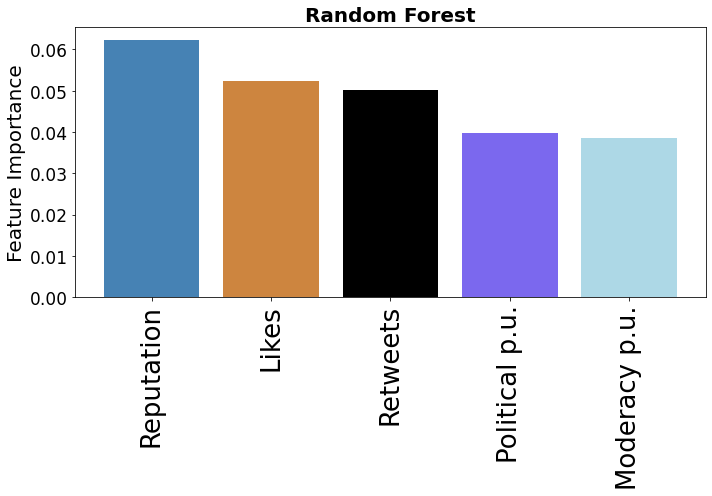

In [72]:
plot_hist_Features(l_features_importances, l_features, 'Rf_TweetsCov19_content_User(reputation)_o_moderacy_all_del')

************************************************
************************************************

## TweetsCov19
### (Content only)

In [21]:
features = df_tweetscov19_user.columns
features

#features = features[2:83]
df_tweetscov19_user = df_tweetscov19_user[features.tolist()]
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference'])
df_tweetscov19_user = df_tweetscov19_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [22]:
features = df_tweetscov19_user.columns
X,y = get_X_y(df_tweetscov19_user, features)

(20000, 80)
(20000,)


In [23]:
X_train, X_test, y_train, y_test= split_train_test_valid(X,y)

(16000, 80)
(4000, 80)
(16000,)
(4000,)


In [24]:
%%time
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.57875
Wall time: 794 ms


In [25]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_RF_Inhalt_all_ohne_moderacy.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [27]:
f_importances = features_classifier_(X, rf_model)
f_importances

index                      Feature  importance
0      10                  readability      0.0456
1       8                     Text_len      0.0449
2      63                         prep      0.0317
3       5                    vader_com      0.0315
4       3                    Vader_neu      0.0300
5      68                         verb      0.0288
6      78                        space      0.0244
7      54                 focuspresent      0.0242
8       4                    Vader_pos      0.0239
9      16                       social      0.0234
10      2                    Vader_neg      0.0226
11     64                      auxverb      0.0223
12     62                      article      0.0222
13     79                         time      0.0208
14      1                    Favorites      0.0200
15      0                     Retweets      0.0198
16     66                         conj      0.0197
17     61                        ipron      0.0195
18     65                       adverb      0.0185
19     69                          adj      0.0182
20     53                    focuspast      0.0158
21     50                        power      0.0155
22     21                         work      0.0152
23      7                 Mentions_num      0.0142
24     37                       posemo      0.0140
25     47                       differ      0.0131
26     77                       motion      0.0131
27     38                       negemo      0.0128
28      6                 Hashtags_num      0.0126
29     73                        quant      0.0122
30     45                       tentat      0.0122
31     70                      compare      0.0120
32     42                      insight      0.0120
33     43                        cause      0.0120
34     48                  affiliation      0.0119
35     46                      certain      0.0118
36     71                     interrog      0.0106
37     49                       achiev      0.0104
38     58                          you      0.0104
39     55                  focusfuture      0.0100
40     51                       reward      0.0099
41     56                            i      0.0098
42     44                      discrep      0.0098
43     12                   Emoji_sent      0.0098
44      9                     URLs_num      0.0097
45     27                     informal      0.0092
46     74                          see      0.0090
47     34                       health      0.0086
48     22                      leisure      0.0086
49     67                       negate      0.0082
50     52                         risk      0.0081
51     11                    Emoji_num      0.0080
52     24                        money      0.0078
53     60                         they      0.0074
54     20                         male      0.0071
55     40                        anger      0.0071
56     57                           we      0.0068
57     75                         hear      0.0066
58     33                         body      0.0065
59     59                        shehe      0.0065
60     72                       number      0.0063
61     29                     netspeak      0.0054
62     23                         home      0.0053
63     13   tweet_politic_polarisation      0.0048
64     26                        death      0.0044
65     76                         feel      0.0043
66     41                          sad      0.0041
67     28                        swear      0.0040
68     19                       female      0.0040
69     36                       ingest      0.0038
70     39                          anx      0.0038
71     14   tweet_science_polarisation      0.0035
72     18                       friend      0.0032
73     15  tweet_moderacy_polarisation      0.0032
74     17                       family      0.0028
75     25                     relegion      0.0026
76     35                       sexual      0.0026
77     30                 

In [28]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.56      0.57      2018
           1       0.57      0.60      0.58      1982

    accuracy                           0.58      4000
   macro avg       0.58      0.58      0.58      4000
weighted avg       0.58      0.58      0.58      4000



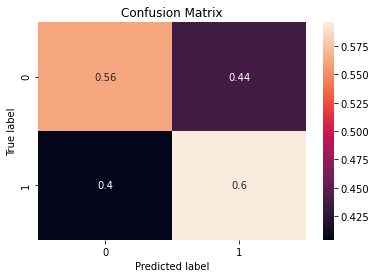

In [29]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [30]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetscov19_sample/Modells/TweetsCov19_RF_Inhalt_all_ohne_moderacy.sav'
#rf_model = pickle.load(open(pfad_modell, 'rb'))

In [31]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 200 , random_state=5, n_jobs=-1)
print_cross_val_score(rf_model, X_test, y_test)

 percision : 0.58 +/- 0.021
 f1        : 0.56 +/- 0.023
 recall    : 0.54 +/- 0.031
Wall time: 12.9 s


********************************************************
********************************************************

## Plot feature Imortances
### TweetCov19 (Content Only)

In [42]:
def plot_hist_Features_content_only(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['peru', 'black', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=18)
    ax.set_ylabel('Feature Importance', fontsize=20)
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
    fig.tight_layout()
    

    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [43]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Retweets', 'Text l.', 'Readability', 'Sentiment']

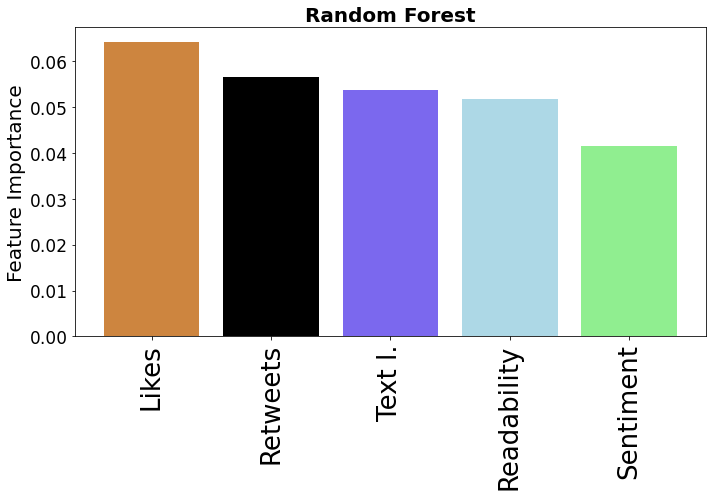

In [44]:
plot_hist_Features_content_only(l_features_importances, l_features, 'Rf_TweetsCov19_content_only_o_moderacy_all_del')

************************************************
************************************************

# Tweetskb
### (Content + User Features)

In [59]:
path = '../data/df_tweetskb_sample_200000.tsv'

df_tweetskb_user = pd.read_csv(path, sep='\t', error_bad_lines=False, names=['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg', 'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num', 'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent', 'tweet_politic_polarisation', 'tweet_science_polarisation', 'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female', 'male' , 'work', 'leisure', 'home', 'money', 'relegion', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body', 'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear', 'feel', 'motion', 'space', 'time', 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio', 'user_Reputation', 'Is_deleted', 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference'])

print('Shape :', df_tweetskb_user.shape)
df_tweetskb_user.head()

Shape : (200000, 95)


Tweet_Id        Username  Retweets  Favorites  Vader_neg  \
0  1259903023549042688  Terrell__green        94        342    -0.1750   
1  1217234013795930112       stargel69         0          0    -0.4490   
2  1189641294215286785      reggie7615         0          0    -0.0000   
3  1224462963873943552         Vuhrezy         0          0    -0.0000   
4  1238813348730261504   KpopOldschool        62         91    -0.0000   

   Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  Text_len  \
0     0.4740     0.3500     0.9601             0             0        75   
1     0.5510     0.0000    -0.5972             0             2        62   
2     0.5540     0.4460     0.9285             0             1        47   
3     1.0000     0.0000     0.0000             0             0        19   
4     1.0000     0.0000     0.0000             0             0       157   

   URLs_num  readability  Emoji_num  Emoji_sent  tweet_politic_polarisation  \
0         0      75.5000          9      0.2184                      0.0000   
1         0      42.4680          0      0.0000                      0.0000   
2         0      94.3180          5      0.6633                      0.0000   
3         0     117.1600          0      0.0000                      0.0000   
4         0      58.4290          0      0.0000                      0.0000   

   tweet_science_polarisation  tweet_moderacy_polarisation  social  family  \
0                      0.0000                       0.0000  0.0000  0.0000   
1                      0.0000                       0.0000  0.0000  0.0000   
2                      0.0000                       0.0000  0.0000  0.0000   
3                      0.0000                       0.0000  0.0000  0.0000   
4                      0.0000                       0.0000  3.5700  0.0000   

   friend  female   male   work  leisure   home  money  relegion  death  \
0  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
1  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
2  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
3  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000   
4  0.0000  3.5700 0.0000 0.0000   7.1400 0.0000 0.0000    0.0000 0.0000   

   informal  swear  netspeak  assent  nonflu  filler   body  health  sexual  \
0    8.3300 0.0000    8.3300  0.0000  8.3300  0.0000 0.0000  0.0000  0.0000   
1   12.5000 0.0000   12.5000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
2    0.0000 0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
3    0.0000 0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   
4    0.0000 0.0000    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000   

   ingest  posemo  negemo     anx  anger    sad  insight  cause  discrep  \
0  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000   0.0000   
1  0.0000  0.0000 12.5000 12.5000 0.0000 0.0000   0.0000 0.0000   0.0000   
2  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000   0.0000   
3  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000  20.0000   
4  0.0000  0.0000  0.0000  0.0000 0.0000 0.0000   0.0000 0.0000   0.0000   

   tentat  certain  differ  affiliation  achiev  power  reward   risk  \
0  0.0000   8.3300  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
1  0.0000   0.0000 12.5000       0.0000  0.0000 0.0000  0.0000 0.0000   
2  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
3  0.0000   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000   
4  0.0000   0.0000  3.5700       0.0000  0.0000 0.0000  0.0000 0.0000   

   focuspast  focuspresent  focusfuture      i     we    you  shehe   they  \
0     0.0000        0.0000       0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
1     0.0000        0.0000       0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
2    20.0000        0.0000       0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
3    20.0000        0.0000       0

In [60]:
features = df_tweetskb_user.columns
#features

In [61]:
df_tweetskb_user['Is_deleted'] = np.where(df_tweetskb_user['Is_deleted'] == True, 0, 1)
df_tweetskb_user.tail()

Tweet_Id         Username  Retweets  Favorites  Vader_neg  \
199995  1206693752246538240  Blackgirl_kaka_         1          0    -0.1140   
199996  1261623817820127233      junicoakiea         0          0    -0.1590   
199997  1233858425857032192       minieschub        25         92    -0.0000   
199998  1210538436630724608      jendeukarea         0          0    -0.3600   
199999  1244279488126562309         oizaabu1        24        280    -0.0000   

        Vader_neu  Vader_pos  vader_com  Hashtags_num  Mentions_num  Text_len  \
199995     0.6590     0.2280     0.4404             0             1        53   
199996     0.6060     0.2350     0.2500             0             0        45   
199997     1.0000     0.0000     0.0000             0             0        32   
199998     0.6400     0.0000    -0.7351             0             0        45   
199999     1.0000     0.0000     0.0000             0             0        43   

        URLs_num  readability  Emoji_num  Emoji_sent  \
199995         1      78.8730          2     -0.0770   
199996         0     112.0850          0      0.0000   
199997         0      35.6050          0      0.0000   
199998         0      92.9650          2     -0.0930   
199999         0      49.4800          0      0.0000   

        tweet_politic_polarisation  tweet_science_polarisation  \
199995                      0.0000                      0.0000   
199996                      0.0000                      0.0000   
199997                      0.0000                      0.0000   
199998                      0.0000                      0.0000   
199999                      0.0000                      0.0000   

        tweet_moderacy_polarisation  social  family  friend  female    male  \
199995                       0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
199996                       0.0000 10.0000  0.0000 10.0000  0.0000  0.0000   
199997                       0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
199998                       0.0000 42.8600 14.2900 14.2900  0.0000 14.2900   
199999                       0.0000 12.5000  0.0000  0.0000  0.0000  0.0000   

         work  leisure   home  money  relegion  death  informal  swear  \
199995 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   
199996 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   
199997 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   
199998 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   
199999 0.0000   0.0000 0.0000 0.0000    0.0000 0.0000    0.0000 0.0000   

        netspeak  assent  nonflu  filler   body  health  sexual  ingest  \
199995    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199996    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199997    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199998    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   
199999    0.0000  0.0000  0.0000  0.0000 0.0000  0.0000  0.0000  0.0000   

        posemo  negemo    anx  anger    sad  insight  cause  discrep  tentat  \
199995  0.0000  0.0000 0.0000 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   
199996  0.0000 10.0000 0.0000 0.0000 0.0000  10.0000 0.0000   0.0000  0.0000   
199997  0.0000  0.0000 0.0000 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   
199998  0.0000  0.0000 0.0000 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   
199999  0.0000  0.0000 0.0000 0.0000 0.0000   0.0000 0.0000   0.0000  0.0000   

        certain  differ  affiliation  achiev  power  reward   risk  focuspast  \
199995   0.0000 11.1100       0.0000  0.0000 0.0000  0.0000 0.0000    11.1100   
199996   0.0000  0.0000      10.0000  0.0000 0.0000  0.0000 0.0000    30.0000   
199997   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000   
199998   0.0000  0.0000       0.0000  0.0000 0.0000  0.0000 0.0000     0.0000   
199999   0.0000  0.0000      12.5000  0.0000 0.0000  0.0000 

In [62]:
print(len(features))
features

95


Index(['Tweet_Id', 'Username', 'Retweets', 'Favorites', 'Vader_neg',
       'Vader_neu', 'Vader_pos', 'vader_com', 'Hashtags_num', 'Mentions_num',
       'Text_len', 'URLs_num', 'readability', 'Emoji_num', 'Emoji_sent',
       'tweet_politic_polarisation', 'tweet_science_polarisation',
       'tweet_moderacy_polarisation', 'social', 'family', 'friend', 'female',
       'male', 'work', 'leisure', 'home', 'money', 'relegion', 'death',
       'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'body',
       'health', 'sexual', 'ingest', 'posemo', 'negemo', 'anx', 'anger', 'sad',
       'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ',
       'affiliation', 'achiev', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'i', 'we', 'you', 'shehe', 'they',
       'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate',
       'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'see', 'hear',
       'feel', 'motion', 'space', 'tim

In [63]:
#df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation','user_science_polarisation.','user_moderacy_polarisation'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'Tweet_Id', 'Username', 'user_num_posted_tweets', 'user_num_deleted_tweets', 'user_Deletion_ratio'])

In [64]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 89)
(200000,)


In [65]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 89)
(40000, 89)
(160000,)
(40000,)


In [66]:
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.572


In [67]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Benutzer_Inhalt_alle_ohne_moderacy.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [68]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59     20093
           1       0.57      0.54      0.56     19907

    accuracy                           0.57     40000
   macro avg       0.57      0.57      0.57     40000
weighted avg       0.57      0.57      0.57     40000



In [69]:
f_importances = features_classifier_(X, rf_model)
f_importances

index                                  Feature  importance
0      83                          user_Reputation      0.0779
1       8                                 Text_len      0.0557
2      10                              readability      0.0552
3      84               user_vadercompound_average      0.0494
4       3                                Vader_neu      0.0308
5       5                                vader_com      0.0305
6      85           tweet_vadercompound_difference      0.0248
7       4                                Vader_pos      0.0246
8      62                                  article      0.0232
9      67                                   negate      0.0231
10     16                                   social      0.0209
11     53                                focuspast      0.0206
12      0                                 Retweets      0.0179
13      2                                Vader_neg      0.0177
14     63                                     prep      0.0174
15     77                                   motion      0.0173
16      1                                Favorites      0.0173
17     78                                    space      0.0164
18     60                                     they      0.0163
19     61                                    ipron      0.0162
20     64                                  auxverb      0.0158
21     68                                     verb      0.0147
22     65                                   adverb      0.0146
23     12                               Emoji_sent      0.0141
24      7                             Mentions_num      0.0139
25     37                                   posemo      0.0134
26     11                                Emoji_num      0.0114
27     55                              focusfuture      0.0110
28     50                                    power      0.0107
29     57                                       we      0.0106
30     48                              affiliation      0.0101
31     47                                   differ      0.0098
32     72                                   number      0.0097
33     27                                 informal      0.0093
34     42                                  insight      0.0093
35     76                                     feel      0.0093
36     45                                   tentat      0.0091
37     69                                      adj      0.0089
38     21                                     work      0.0089
39     46                                  certain      0.0088
40     38                                   negemo      0.0087
41     51                                   reward      0.0084
42     22                                  leisure      0.0080
43     73                                    quant      0.0079
44      6                             Hashtags_num      0.0077
45     44                                  discrep      0.0076
46     43                                    cause      0.0075
47     70                                  compare      0.0070
48     49                                   achiev      0.0069
49     54                             focuspresent      0.0069
50     66                                     conj      0.0065
51     20                                     male      0.0064
52     29                                 netspeak      0.0061
53     33                                     body      0.0060
54     74                                      see      0.0056
55     71                                 interrog      0.0053
56     58                                      you      0.0052
57     24                                    money      0.0052
58      9                                 URLs_num      0.0050
59     40                                    anger      0.0048
60     59                                    shehe      0.0044
61     19                                   female      0.0044
62     34                          

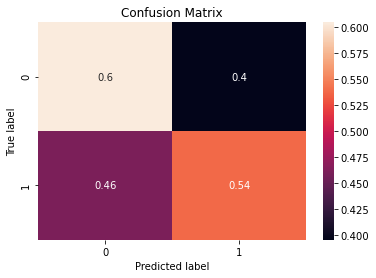

In [70]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [71]:
#pfad_model = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Benutzer_Inhalt_alle_ohne_moderacy.sav'
#rf_modell = pickle.load(open(pfad_modell, 'rb'))

In [72]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 200 , random_state=5, n_jobs=-1)
print_cross_val_score(clf_cv, X_test, y_test)

 percision : 0.57 +/- 0.007
 f1        : 0.55 +/- 0.008
 recall    : 0.53 +/- 0.009
Wall time: 2min 31s


*****************************************************
*****************************************************

## Plot feature Imortances
### Tweetkb (Content + User)

In [26]:
def plot_hist_Features_kb(l_features_importances, l_features, titel):
    
    #colors = ['mediumorchid', 'gold', 'green', 'peru', 'red', 'mediumslateblue', 'deepskyblue', 'darkkhaki', 'brown']
    colors = ['steelblue','Black', 'peru', 'mediumslateblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
   #plt.legend()
    plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [27]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Reputation', 'Text l.', 'Readability', 'Sentiment', 'Verb']

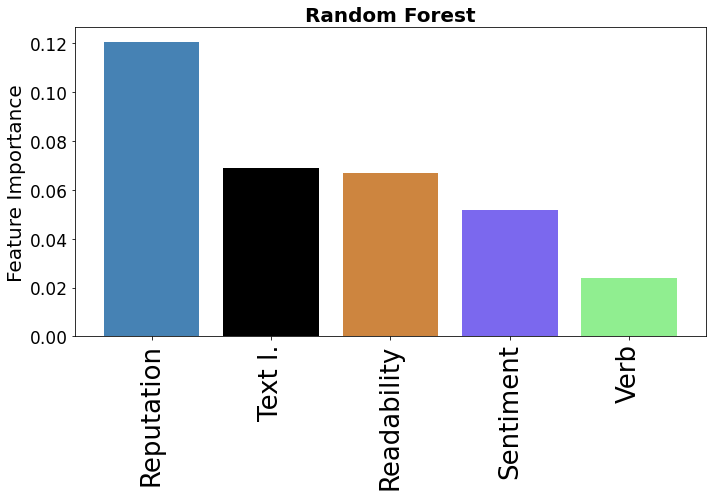

In [28]:
plot_hist_Features_kb(l_features_importances, l_features, 'Rf_Tweetskb_content_User(reputation)_2_o_moderacy_all_del')

***********************************************************************
***********************************************************************

## Tweetskb
### Content only


In [73]:
features = df_tweetskb_user.columns
features

#features = features[2:83]
df_tweetskb_user = df_tweetskb_user[features.tolist()]
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_vadercompound_average', 'tweet_vadercompound_difference', 'tweet_political_polarisation_difference', 'tweet_science_polarisation_difference', 'tweet_moderacy_polarisation_difference'])
df_tweetskb_user = df_tweetskb_user.drop(columns=[ 'user_political_polarisation', 'user_science_polarisation', 'user_moderacy_polarisation', 'user_Reputation'])


In [74]:
features = df_tweetskb_user.columns
X,y = get_X_y(df_tweetskb_user, features)

(200000, 80)
(200000,)


In [75]:
X_train, X_test, y_train, y_test = split_train_test_valid(X,y)

(160000, 80)
(40000, 80)
(160000,)
(40000,)


In [76]:
%%time
rf_model = fit_random_forest_clf(X_train, y_train)
test_random_forest_clf(rf_model, X_test, y_test)

Accuracy : 0.556525
Wall time: 13.2 s


In [77]:
#pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Inhalt_alle_ohne_moderacy.sav'
#pickle.dump(rf_model, open(pfad_modell, 'wb'))

In [78]:
f_importances = features_classifier_(X, rf_model)
f_importances

index                      Feature  importance
0       8                     Text_len      0.0738
1      10                  readability      0.0709
2       5                    vader_com      0.0402
3       3                    Vader_neu      0.0387
4       4                    Vader_pos      0.0312
5      62                      article      0.0268
6      67                       negate      0.0266
7      16                       social      0.0242
8      53                    focuspast      0.0236
9       0                     Retweets      0.0225
10      2                    Vader_neg      0.0224
11      1                    Favorites      0.0217
12     63                         prep      0.0198
13     77                       motion      0.0197
14     60                         they      0.0189
15     78                        space      0.0188
16     61                        ipron      0.0186
17     64                      auxverb      0.0181
18     12                   Emoji_sent      0.0170
19     65                       adverb      0.0170
20     68                         verb      0.0170
21      7                 Mentions_num      0.0159
22     37                       posemo      0.0155
23     11                    Emoji_num      0.0137
24     55                  focusfuture      0.0124
25     50                        power      0.0124
26     57                           we      0.0121
27     48                  affiliation      0.0116
28     47                       differ      0.0112
29     72                       number      0.0111
30     42                      insight      0.0109
31     76                         feel      0.0108
32     27                     informal      0.0105
33     69                          adj      0.0104
34     45                       tentat      0.0104
35     46                      certain      0.0103
36     21                         work      0.0101
37     38                       negemo      0.0100
38     51                       reward      0.0097
39     22                      leisure      0.0093
40     73                        quant      0.0092
41     43                        cause      0.0088
42      6                 Hashtags_num      0.0088
43     44                      discrep      0.0086
44     70                      compare      0.0082
45     54                 focuspresent      0.0080
46     49                       achiev      0.0078
47     66                         conj      0.0076
48     20                         male      0.0074
49     33                         body      0.0069
50     29                     netspeak      0.0067
51     74                          see      0.0065
52     71                     interrog      0.0062
53     58                          you      0.0060
54     24                        money      0.0059
55      9                     URLs_num      0.0056
56     40                        anger      0.0055
57     59                        shehe      0.0052
58     19                       female      0.0051
59     34                       health      0.0050
60     75                         hear      0.0046
61     56                            i      0.0046
62     36                       ingest      0.0045
63     52                         risk      0.0044
64     28                        swear      0.0040
65     35                       sexual      0.0039
66     18                       friend      0.0039
67     41                          sad      0.0038
68     17                       family      0.0037
69     25                     relegion      0.0031
70     23                         home      0.0031
71     30                       assent      0.0023
72     39                          anx      0.0023
73     26                        death      0.0023
74     31                       nonflu      0.0016
75     13   tweet_politic_polarisation      0.0011
76     14   tweet_science_polarisation      0.0009
77     15  tweet_moderacy_

In [79]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.58      0.57     20093
           1       0.56      0.54      0.55     19907

    accuracy                           0.56     40000
   macro avg       0.56      0.56      0.56     40000
weighted avg       0.56      0.56      0.56     40000



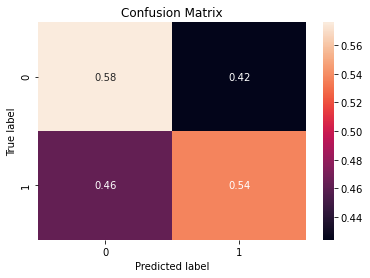

In [80]:
plot_confusion_matrix(y_test, y_pred, rf_model.classes_, 'Confusion Matrix')

In [81]:
y_prob_test = rf_model.predict_proba(X_test)
print('Logarithmic loss für Test data', log_loss(y_test, y_prob_test))

Logarithmic loss für Test data 0.6952082157096873


In [82]:
pfad_modell = 'C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_sample/Tweetskb_sample/Modells/TweetsKB_RF_Inhalt_alle_ohne_moderacy.sav'
#rf_regression = pickle.load(open(pfad_modell, 'rb'))

In [83]:
%%time
clf_cv = RandomForestClassifier(n_estimators = 200 , random_state=5, n_jobs=-1)
print_cross_val_score(clf_cv, X_test, y_test)

 percision : 0.55 +/- 0.007
 f1        : 0.54 +/- 0.009
 recall    : 0.53 +/- 0.011
Wall time: 2min 18s


***************************************************
***************************************************

## Plot feature Imortances
### Tweetkb (Content Only )

In [73]:
def plot_hist_Features_content_only_kb(l_features_importances, l_features, titel):
    
    #colors = ['red', 'blue', 'peru', 'orange', 'yellow', 'mediumslateblue', 'deepskyblue', 'steelblue']
    colors = ['black', 'peru', 'mediumslateblue', 'lightblue', 'lightgreen']
    
    x = np.arange(len(l_features))
    #figure(figsize=(12, 8), dpi=80)
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [10,7]
    
    #ax.hist(df1, df2 = bins,  color = 'mediumslateblue', label = 'nicht gelöscht')
    ax.bar(x, l_features_importances, color = colors)
    ax.set_title('Random Forest', fontweight="bold", fontsize=20)
    #ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(l_features, fontsize=26,  rotation='vertical')
           
    #ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=17)

    fig.tight_layout()
 
    #plt.legend()
    #plt.savefig('C:/Mo/tweetDB/tweetscov19/TweetsCov19_tsv/data_aus_tsv/plot/classifeier/'+titel+'.pdf')

In [74]:
l_features = f_importances.Feature.tolist()
l_features = l_features[:5]

l_features_importances = f_importances.importance.tolist()
l_features_importances = l_features_importances[0:5]
l_features

['Likes', 'Readability', 'Text l.', 'Retweets', 'Sentiment']

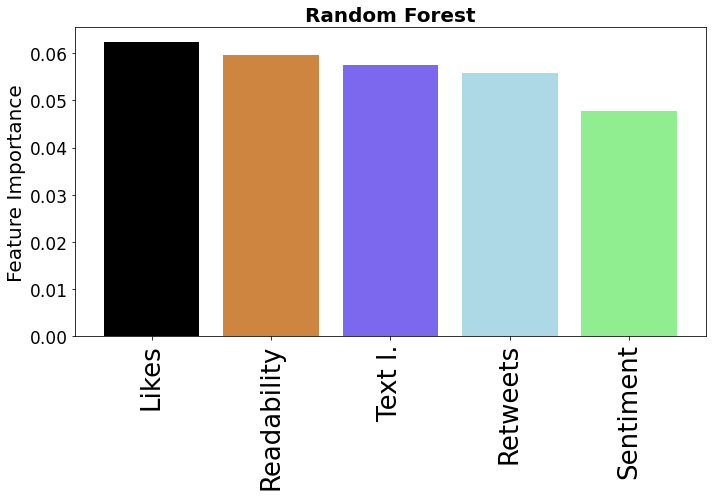

In [75]:
plot_hist_Features_content_only_kb(l_features_importances, l_features, 'Rf_Tweetskb_content_only_ohne_moderacy_alle_del')